# FloPy Model Grids - Geoprocessing

## Notebook Setup

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon, LineString
import flopy
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen
import flopy.plot.styles as styles

In [2]:
# import all plot style information from defaults.py
from defaults import *

/Users/jdhughes/Documents/Publications/jdhughes/JDH Publications/Ground Water/2022/mf6-flopy/notebooks/defaults.py:54: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  temp_cmap = mpl.cm.get_cmap(intersection_cmap)


In [3]:
fine_topo = flopy.utils.Raster.load("./grid_data/fine_topo.asc")

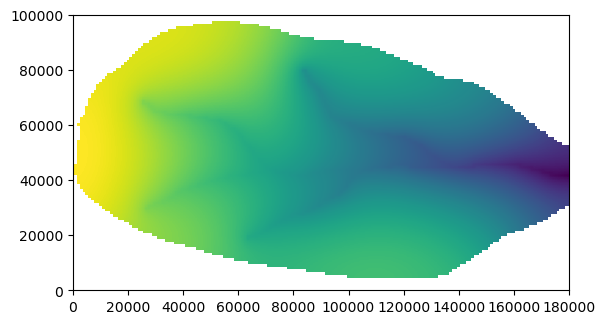

<AxesSubplot: >

In [4]:
fine_topo.plot()

In [5]:
Lx = 180000
Ly = 100000
extent = (0, Lx, 0, Ly)
levels = np.arange(10, 110, 10)
vmin, vmax = 0.0, 100.0

In [6]:
temp_path = "./temp"
if not os.path.isdir(temp_path):
    os.mkdir(temp_path)

In [7]:
figwidth = 180  # 90 # mm
figwidth = figwidth / 10 / 2.54  # inches
figheight = figwidth
figsize = (figwidth, figheight)

# Basin Example

len boundary 55
Len segment:  38
Len segment:  14
Len segment:  12
Len segment:  13


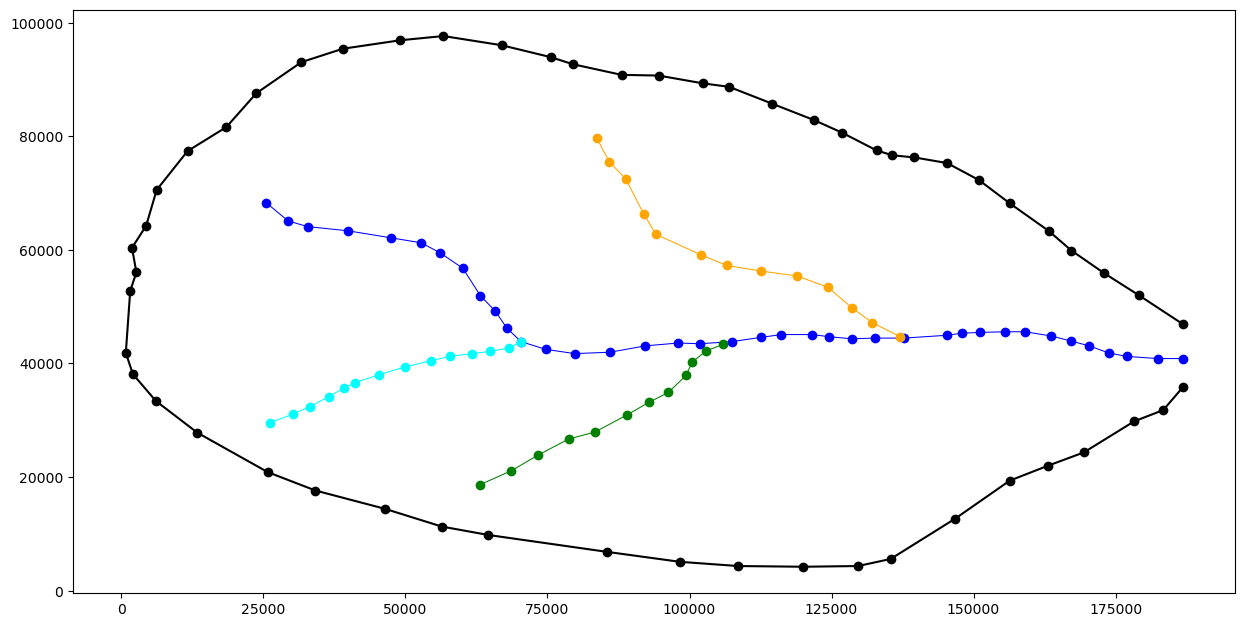

In [8]:
boundary_polygon = string2geom(boundary)
print("len boundary", len(boundary_polygon))
bp = np.array(boundary_polygon)

sgs = [
    string2geom(sg) for sg in (streamseg1, streamseg2, streamseg3, streamseg4)
]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")

riv_colors = ("blue", "cyan", "green", "orange", "red")

ax.plot(bp[:, 0], bp[:, 1], "ko-")
for idx, sg in enumerate(sgs):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

180000 100000 50 90


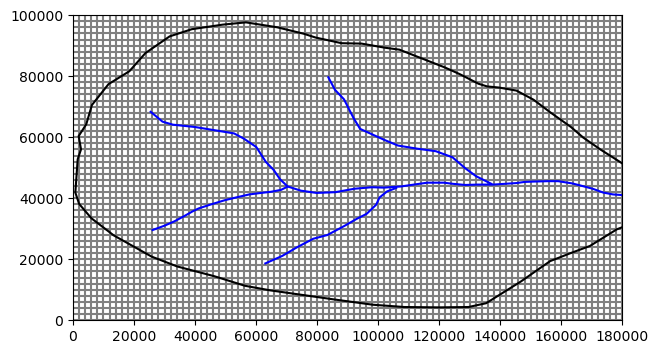

In [9]:
# Create a regular MODFLOW grid

dx = dy = 2000
nrow = int(Ly / dy)
ncol = int(Lx / dx)
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
regular_grid = StructuredGrid(delr=delr, delc=delc, xoff=0.0, yoff=0.0)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect("equal")
regular_grid.plot(ax=ax)
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

In [10]:
def set_idomain(grid, boundary):
    from flopy.utils.gridintersect import GridIntersect
    from shapely.geometry import Polygon

    ix = GridIntersect(grid, method="vertex", rtree=True)
    result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]
    idx = np.array(idx, dtype=int)
    nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    print(idx.shape, idx.ndim)
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])
    # idx = (idx[:, 0], idx[:, 1])
    idomain = np.zeros(grid.shape[1:], dtype=int)
    idomain[idx] = 1
    idomain = idomain.reshape(grid.shape)
    grid.idomain = idomain

In [11]:
# Create a regular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 1666.66666667
nlay = 1
nrow = int(Ly / dy) + 1
ncol = int(Lx / dx) + 1
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
top = np.ones((nrow, ncol)) * 1000.0
botm = np.ones((nlay, nrow, ncol)) * -100.0
regular_grid = StructuredGrid(
    nlay=nlay, delr=delr, delc=delc, xoff=0.0, yoff=0.0, top=top, botm=botm
)

set_idomain(regular_grid, boundary_polygon)

180000 100000 60 108
(4580, 2) 2


In [12]:
top_rg = fine_topo.resample_to_grid(
    regular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [13]:
regular_grid.shape

(1, 60, 108)

In [14]:
ixs = flopy.utils.GridIntersect(regular_grid, method="structured")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_rg = np.zeros(regular_grid.shape[1:])
for loc in cellids:
    intersection_rg[loc] = 1

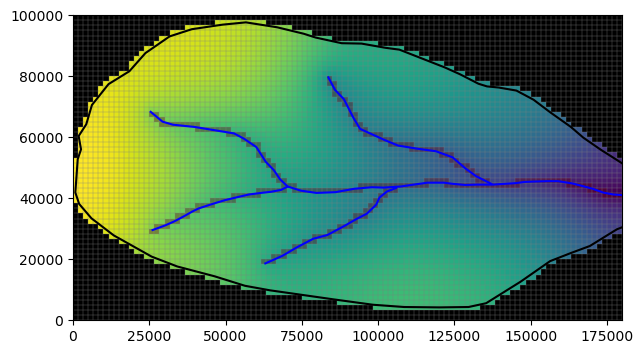

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=regular_grid)
ax.set_aspect("equal")
pmv.plot_array(top_rg)
pmv.plot_array(
    intersection_rg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
pmv.plot_grid(lw=0.25, color="0.5")
pmv.plot_inactive()
# regular_grid.plot(ax=ax, )
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

In [16]:
# Create an irregular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 5000

In [17]:
# create transition cells
multiplier = 1.175
transition = 20000.
ncells = 7
smoothr = [transition*(multiplier - 1.) / (multiplier**float(ncells) - 1.)]
for i in range(ncells - 1):
    smoothr.append(smoothr[i]*multiplier)
smooth = smoothr.copy()
smooth.reverse()

In [18]:
# build the irregular grid
dx = 9 * [5000] + smooth + 15 * [1666.66666667] + smoothr + 14 * [5000]
dy = 4 * [5000] + smooth + 12 * [1666.66666667] + smoothr + 4 * [5000]

nlay = 1
ncol = len(dx)
nrow = len(dy)

top = np.ones((nrow, ncol)) * 1000.0
botm = np.ones((nlay, nrow, ncol)) * -100.0

delr = np.array(dx)
delc = np.array(dy)
irregular_grid = StructuredGrid(
    nlay=nlay, delr=delr, delc=delc, xoff=0.0, yoff=0.0, top=top, botm=botm
)
set_idomain(irregular_grid, boundary_polygon)

(1546, 2) 2


In [19]:
top_ig = fine_topo.resample_to_grid(
    irregular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [20]:
ixs = flopy.utils.GridIntersect(irregular_grid, method="structured")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_ig = np.zeros(irregular_grid.shape[1:])
for loc in cellids:
    intersection_ig[loc] = 1

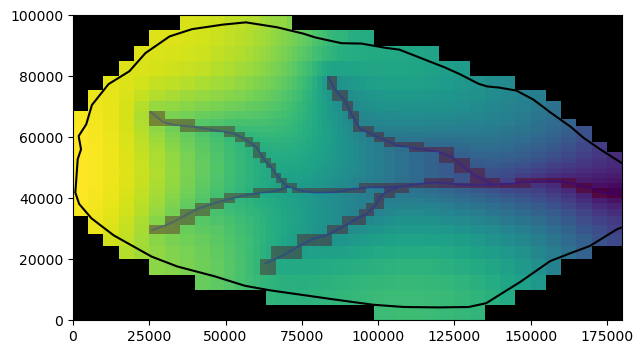

In [21]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=irregular_grid)
ax.set_aspect("equal")
pmv.plot_array(top_ig)
pmv.plot_array(
    intersection_ig,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
# pmv.plot_grid()
pmv.plot_inactive()
# regular_grid.plot(ax=ax, )
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-", alpha=0.2)

In [22]:
# nested grid
from flopy.utils.lgrutil import Lgr

nlayp = 1
dx = 5000
nrowp = int(Ly / dx)
ncolp = int(Lx / dx)
delrp = dx
delcp = dx
# topp = 1000.0
# botmp = [-100.]
topp = np.ones((nrowp, ncolp)) * 1000.0
botmp = np.ones((nlayp, nrowp, ncolp)) * -100.0

idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[0, 8:12, 13:18] = 0

ncpp = 3
ncppl = [1]

lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=ncpp,
    ncppl=ncppl,
    xllp=0.0,
    yllp=0.0,
)

delr = np.array(ncolp * [dx])
delc = np.array(nrowp * [dx])
regular_gridp = StructuredGrid(
    nlay=1, delr=delr, delc=delc, idomain=idomainp, top=topp, botm=botmp
)
set_idomain(regular_gridp, boundary_polygon)

delr_child, delc_child = lgr.get_delr_delc()
xoff, yoff = lgr.get_lower_left()
nrowc, ncolc = delc_child.shape[0], delr_child.shape[0]
topc = np.ones((nrowc, ncolc)) * 1000.0
botmc = np.ones((nlayp, nrowc, ncolc)) * -100.0
regular_gridc = StructuredGrid(
    delr=delr_child,
    delc=delc_child,
    xoff=xoff,
    yoff=yoff,
    idomain=idomainp,
    top=topc,
    botm=botmc,
)

extent_child = regular_gridc.extent

nested_grid = [regular_gridp, regular_gridc]

(548, 2) 2


In [23]:
top_ngp = fine_topo.resample_to_grid(
    regular_gridp,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)
top_ngc = fine_topo.resample_to_grid(
    regular_gridc,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)
top_nested_grid = [top_ngp, top_ngc]

In [24]:
ixs = flopy.utils.GridIntersect(regular_gridp, method="structured")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_ngp = np.zeros(regular_gridp.shape[1:])
for loc in cellids:
    intersection_ngp[loc] = 1
intersection_ngp[idomainp[0] == 0] = 0

ixs = flopy.utils.GridIntersect(regular_gridc, method="structured")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_ngc = np.zeros(regular_gridc.shape[1:])
for loc in cellids:
    intersection_ngc[loc] = 1

intersection_nested_grid = [intersection_ngp, intersection_ngc]

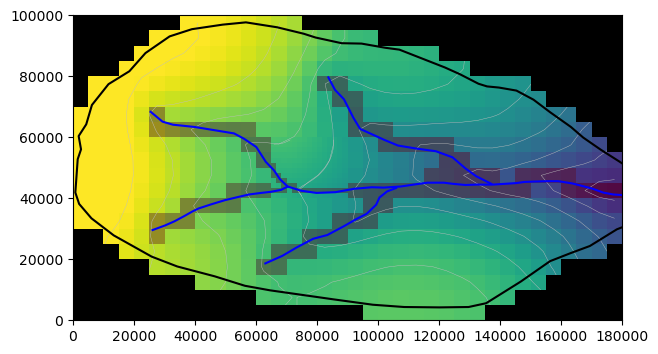

In [25]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=regular_gridp, extent=extent)
pmv.plot_inactive()
pmv.plot_array(top_ngp, vmin=vmin, vmax=vmax)
pmv.plot_array(
    intersection_nested_grid[0],
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
cgp = pmv.contour_array(top_ngp, levels=levels, linewidths=0.3, colors="0.75")
pmv.plot_inactive(zorder=100)
ax.set_aspect("equal")
# extent = pmv.extent

pmvc = flopy.plot.PlotMapView(modelgrid=regular_gridc, ax=ax, extent=extent)
# pmvc.plot_grid()
pmvc.plot_array(top_ngc, vmin=vmin, vmax=vmax)
pmvc.plot_array(
    intersection_nested_grid[1],
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
cgc = pmvc.contour_array(top_ngc, levels=levels, linewidths=0.3, colors="0.75")

# regular_gridp.plot(ax=ax)

ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

In [26]:
# create a polygon of the common refinement area for the quadtree grid
lgr_poly = [
    [
        (extent_child[0], extent_child[2]),
        (extent_child[0], extent_child[3]),
        (extent_child[1], extent_child[3]),
        (extent_child[1], extent_child[2]),
        (extent_child[0], extent_child[2]),
    ]
]
lgr_poly

[[(65000.0, 40000.0),
  (65000.0, 60000.0),
  (90000.0, 60000.0),
  (90000.0, 40000.0),
  (65000.0, 40000.0)]]

In [27]:
# quadtree grid
sim = flopy.mf6.MFSimulation()
gwf = gwf = flopy.mf6.ModflowGwf(sim)
dx = dy = 5000.0
nr = int(Ly / dy)
nc = int(Lx / dx)
dis6 = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=nr,
    ncol=nc,
    delr=dy,
    delc=dx,
)
g = Gridgen(gwf.modelgrid, model_ws=temp_path)
adpoly = [
    [[(1000, 1000), (3000, 1000), (3000, 2000), (1000, 2000), (1000, 1000)]]
]
adpoly = boundary_polygon + [boundary_polygon[0]]
adpoly = [[adpoly]]
g.add_refinement_features([lgr_poly], "polygon", 2, range(1))

refine_line = sgs
g.add_refinement_features(refine_line, "line", 2, range(1))
g.build(verbose=False)

gridprops_vg = g.get_gridprops_vertexgrid()
quadtree_grid = flopy.discretization.VertexGrid(**gridprops_vg)
set_idomain(quadtree_grid, boundary_polygon)

(1694, 1) 2


In [28]:
top_qg = fine_topo.resample_to_grid(
    quadtree_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [29]:
ixs = flopy.utils.GridIntersect(quadtree_grid, method="vertex")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_qg = np.zeros(quadtree_grid.shape[1:])
for loc in cellids:
    intersection_qg[loc] = 1

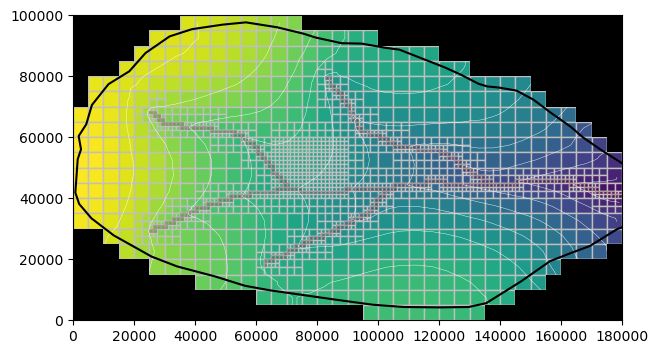

In [30]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=quadtree_grid)
# pmv.plot_grid()
pmv.plot_array(top_qg, ec="0.75")
pmv.plot_array(
    intersection_qg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
cg = pmv.contour_array(top_qg, levels=levels, linewidths=0.3, colors="white")
pmv.plot_inactive(zorder=100)
ax.set_aspect("equal")
# quadtree_grid.plot(ax=ax)

ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    # ax.plot(sa[:, 0], sa[:, 1], "b-")

In [31]:
nodes = []
for sg in sgs:
    sg_densify = densify_geometry(sg, 2000)
    nodes.extend(sg_densify)
for x in regular_gridc.get_xvertices_for_layer(0)[0, :]:
    for y in regular_gridc.get_yvertices_for_layer(0)[:, 0]:
        nodes.append((x, y))    
nodes = np.array(nodes)

In [32]:
tri = Triangle(
    maximum_area=5000 * 5000, angle=30, nodes=nodes, model_ws=temp_path
)
poly = bp
tri.add_polygon(poly)
tri.build(verbose=False)


cell2d = tri.get_cell2d()
vertices = tri.get_vertices()

top = np.ones(tri.ncpl) * 1000.0
botm = np.ones((1, tri.ncpl)) * -100.0
idomain = np.ones((1, tri.ncpl), dtype=int)

triangular_grid = VertexGrid(
    vertices=vertices,
    cell2d=cell2d,
    idomain=idomain,
    nlay=1,
    ncpl=tri.ncpl,
    top=top,
    botm=botm,
)

In [33]:
top_tg = fine_topo.resample_to_grid(
    triangular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [34]:
ixs = flopy.utils.GridIntersect(triangular_grid, method="vertex")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_tg = np.zeros(triangular_grid.shape[1:])
for loc in cellids:
    intersection_tg[loc] = 1

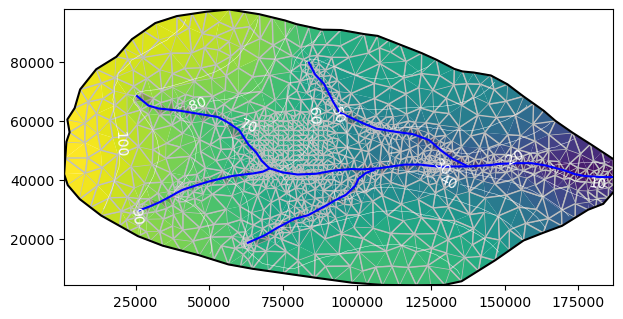

In [35]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect("equal")

pmv = flopy.plot.PlotMapView(modelgrid=triangular_grid)

pmv.plot_array(top_tg, ec="0.75")
pmv.plot_array(
    intersection_tg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
cg = pmv.contour_array(top_tg, levels=levels, linewidths=0.3, colors="white")
ax.clabel(cg, cg.levels, inline=True, fmt="%1.0f", fontsize=10)

pmv.plot_inactive(zorder=100)

if True:
    ax.plot(bp[:, 0], bp[:, 1], "k-")
    for sg in sgs:
        sa = np.array(sg)
        ax.plot(sa[:, 0], sa[:, 1], "b-")

In [36]:
# create vor object and VertexGrid from the triangle object tri
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
idomain = np.ones((1, vor.ncpl), dtype=int)
voronoi_grid = VertexGrid(**gridprops, nlay=1, idomain=idomain)

In [37]:
top_vg = fine_topo.resample_to_grid(
    voronoi_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [38]:
ixs = flopy.utils.GridIntersect(voronoi_grid, method="vertex")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_vg = np.zeros(voronoi_grid.shape[1:])
for loc in cellids:
    intersection_vg[loc] = 1

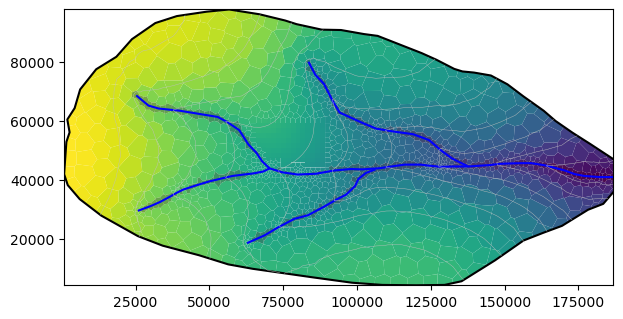

In [39]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=voronoi_grid)
ax.set_aspect("equal")
pmv.plot_array(top_vg)
pmv.plot_array(
    intersection_vg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
# pmv.plot_grid()
pmv.plot_inactive()
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

cg = pmv.contour_array(top_vg, levels=levels, linewidths=0.3, colors="0.75")

In [40]:
# create numpy array of lgr_poly for plotting
lgr_poly_array = np.array(lgr_poly).squeeze()
lgr_poly_array

array([[65000., 40000.],
       [65000., 60000.],
       [90000., 60000.],
       [90000., 40000.],
       [65000., 40000.]])

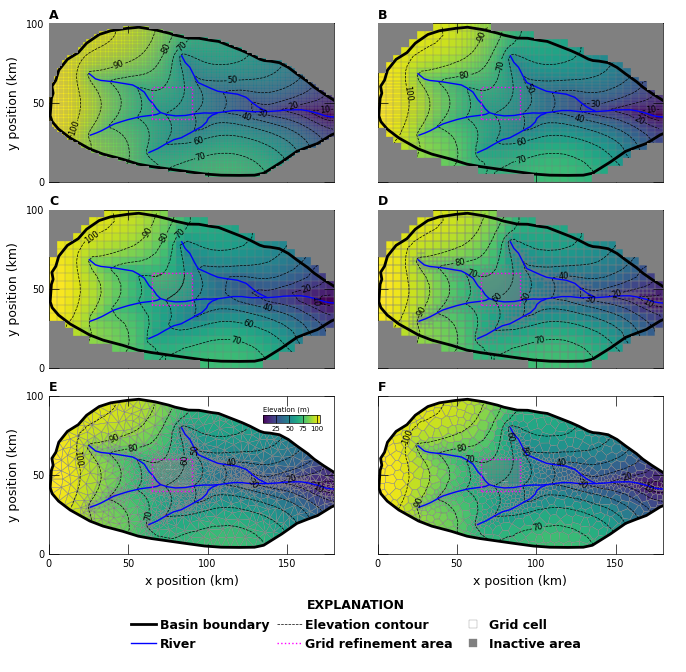

In [48]:
# Make a plot of the six grids
figwidth = 17.15 / 2.54
figheight = 3.66 * (Ly / Lx) * 8.25 / 2.54
grids = [
    regular_grid,
    irregular_grid,
    nested_grid,
    quadtree_grid,
    triangular_grid,
    voronoi_grid,
    None,
]
topo_grids = [top_rg, top_ig, top_nested_grid, top_qg, top_tg, top_vg]
extent = (0, 180000, 0, 100000)
cbar_axis = [0.75, 0.825, 0.2, 0.05]

with styles.USGSMap():
    fig = plt.figure(figsize=(figwidth, figheight), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=16, figure=fig)
    axs = [fig.add_subplot(gs[:5, 0])]
    axs.append(fig.add_subplot(gs[:5, 1]))
    axs.append(fig.add_subplot(gs[5:10, 0]))
    axs.append(fig.add_subplot(gs[5:10, 1]))
    axs.append(fig.add_subplot(gs[10:15, 0]))
    axs.append(fig.add_subplot(gs[10:15, 1]))
    axs.append(fig.add_subplot(gs[15:, :]))

    for idx, ax in enumerate(axs[:-1]):
        g = grids[idx]
        t = topo_grids[idx]
        if g is not None:
            if isinstance(g, list):
                g = g[0]
                t = t[0]

            pmv = flopy.plot.PlotMapView(modelgrid=g, ax=ax)
            
            v = pmv.plot_array(t)
            pmv.plot_grid(**grid_dict)
            cg = pmv.contour_array(t, **contour_dict)
            pmv.ax.clabel(cg, cg.levels, **clabel_dict)
            pmv.plot_inactive(color_noflow="gray", zorder=100)

            if isinstance(grids[idx], list):
                gg = grids[idx]
                tt = topo_grids[idx]
                for g, t in zip(gg[1:], tt[1:]):
                    pmvc = flopy.plot.PlotMapView(
                        modelgrid=g, ax=ax, extent=extent
                    )
                    pmvc.plot_array(top_ngc, vmin=vmin, vmax=vmax)
                    pmvc.plot_grid(**grid_dict)
                    cgc = pmvc.contour_array(top_ngc, **contour_dict)
                    
            # plot lgr polyline
            ax.plot(lgr_poly_array[:, 0], lgr_poly_array[:, 1], zorder=101, **refinement_dict)

            ax.set_aspect("equal")
            ax.set_axisbelow(False)

            ax.set_xlim(extent[0], extent[1])
            ax.set_xticks(np.arange(0, 200000, 50000))
            if idx in (4, 5):
                ax.set_xticklabels(np.arange(0, 200, 50))
                ax.set_xlabel("x position (km)")
            else:
                ax.set_xticklabels([])

            ax.set_ylim(extent[2], extent[3])
            ax.set_yticks(np.arange(0, 150000, 50000))
            if idx in (0, 2, 4):
                ax.set_yticklabels(np.arange(0, 150, 50))
                ax.set_ylabel("y position (km)")
            else:
                ax.set_yticklabels([])

            styles.heading(ax, idx=idx)
            if True:
                ax.plot(bp[:, 0], bp[:, 1], "k-", lw=2.0)
                for sg in sgs:
                    sa = np.array(sg)
                    ax.plot(sa[:, 0], sa[:, 1], **river_dict)

            # colorbar
            if idx == 4:
                cax = ax.inset_axes(
                    cbar_axis,
                )
                cax.set_axisbelow(False)
                cbar = plt.colorbar(
                    v,
                    orientation="horizontal",
                    shrink=0.5,
                    cax=cax,
                    ticks=[25, 50, 75, 100],
                )
                cbar.ax.tick_params(
                    labelsize=5,
                    labelcolor="black",
                    color="black",
                    length=6,
                    pad=2,
                )
                cbar.ax.set_title(
                    "Elevation (m)", pad=2.5, loc="left", fontdict=font_dict
                )

    # legend
    ax = axs[-1]
    xy0 = (-100, -100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    ax.axhline(
        xy0[0],
        color="black",
        lw=2,
        label="Basin boundary",
    )
    ax.axhline(
        xy0[0],
        **river_dict,
        label="River",
    )
    ax.axhline(
        xy0[0],
        color=contour_color,
        lw=0.5,
        ls="--",
        label="Elevation contour",
    )
    ax.axhline(
        xy0[0],
        label="Grid refinement area",
        **refinement_dict,
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="white",
        markeredgewidth=0.25,
        lw=0,
        label="Grid cell",
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="gray",
        markeredgewidth=0.25,
        lw=0,
        label="Inactive area",
    )
    styles.graph_legend(
        ax,
        ncol=3,
        loc="lower center",
        labelspacing=0.5,
        columnspacing=0.6,
        handletextpad=0.3,
    )

    fpth = os.path.join("..", "doc", "figures", "grids_geoprocessing.png")
    plt.savefig(fpth, dpi=300);

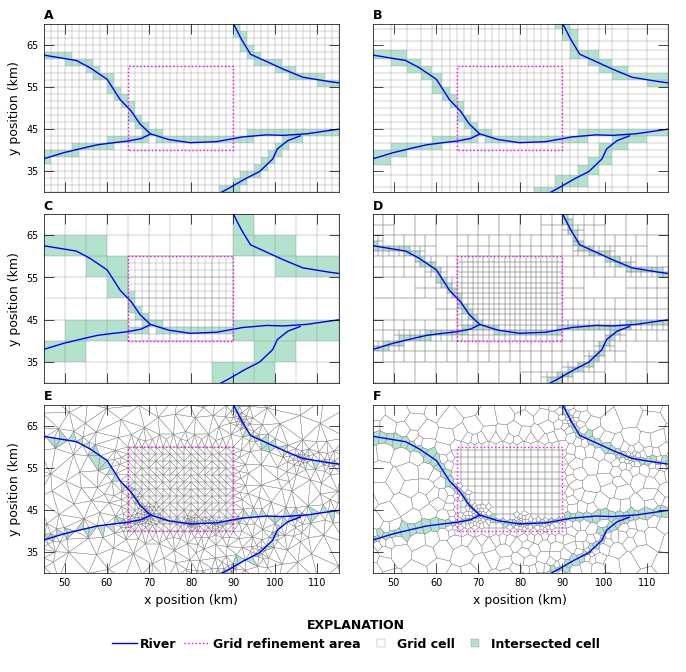

In [47]:
# Make a plot of the river intersection for the six grids
figwidth = 17.15 / 2.54
figheight = 3.66 * (Ly / Lx) * 8.25 / 2.54
grids = [
    regular_grid,
    irregular_grid,
    nested_grid,
    quadtree_grid,
    triangular_grid,
    voronoi_grid,
    None,
]
intersections = [
    intersection_rg,
    intersection_ig,
    intersection_nested_grid,
    intersection_qg,
    intersection_tg,
    intersection_vg,
    None,
]
extent = list(extent_child)
de = 10000.0
extent[0] -= 2.0 * de
extent[1] += 2.5 * de
extent[2] -= de
extent[3] += de


with styles.USGSMap():
    fig = plt.figure(figsize=(figwidth, figheight), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=16, figure=fig)
    axs = [fig.add_subplot(gs[:5, 0])]
    axs.append(fig.add_subplot(gs[:5, 1]))
    axs.append(fig.add_subplot(gs[5:10, 0]))
    axs.append(fig.add_subplot(gs[5:10, 1]))
    axs.append(fig.add_subplot(gs[10:15, 0]))
    axs.append(fig.add_subplot(gs[10:15, 1]))
    axs.append(fig.add_subplot(gs[15:, :]))

    for idx, ax in enumerate(axs[:-1]):
        g = grids[idx]
        t = intersections[idx]
        if g is not None:
            if isinstance(g, list):
                g = g[0]
                t = t[0]

            pmv = flopy.plot.PlotMapView(modelgrid=g, ax=ax, extent=extent)

            v = pmv.plot_array(t, masked_values=(0,), cmap=intersection_cmap)
            pmv.plot_grid(**grid_dict)

            pmv.plot_inactive(color_noflow="gray", zorder=100)

            if isinstance(grids[idx], list):
                gg = grids[idx]
                tt = intersections[idx]
                for g, t in zip(gg[1:], tt[1:]):
                    pmvc = flopy.plot.PlotMapView(
                        modelgrid=g, ax=ax, extent=extent
                    )
                    pmvc.plot_array(
                        t, masked_values=(0,), cmap=intersection_cmap
                    )
                    pmvc.plot_grid(**grid_dict)

            # plot lgr polyline
            ax.plot(lgr_poly_array[:, 0], lgr_poly_array[:, 1], zorder=101, **refinement_dict)

            
            ax.set_aspect("equal")
            ax.set_axisbelow(False)

            ax.set_xlim(extent[0], extent[1])
            ax.set_xticks(np.arange(50000, 120000, 10000))
            if idx in (4, 5):
                ax.set_xticklabels(np.arange(50, 120, 10))
                ax.set_xlabel("x position (km)")
            else:
                ax.set_xticklabels([])

            ax.set_ylim(extent[2], extent[3])
            ax.set_yticks(np.arange(35000, 70000, 10000))
            if idx in (0, 2, 4):
                ax.set_yticklabels(np.arange(35, 75, 10))
                ax.set_ylabel("y position (km)")
            else:
                ax.set_yticklabels([])

            styles.heading(ax, idx=idx)
            if True:
                ax.plot(bp[:, 0], bp[:, 1], "k-", lw=2.0)
                for sg in sgs:
                    sa = np.array(sg)
                    ax.plot(sa[:, 0], sa[:, 1], **river_dict)

    # legend
    ax = axs[-1]
    xy0 = (-100, -100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    ax.axhline(xy0[0], **river_dict, label="River")
    ax.axhline(
        xy0[0],
        label="Grid refinement area",
        **refinement_dict,
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="white",
        markeredgewidth=0.25,
        lw=0,
        label="Grid cell",
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mfc=intersection_rgba,
        mec="0.5",
        markeredgewidth=0.25,
        lw=0,
        label="Intersected cell",
    )
    styles.graph_legend(
        ax,
        ncol=4,
        loc="lower center",
        labelspacing=0.5,
        columnspacing=0.6,
        handletextpad=0.3,
    )

    fpth = os.path.join("..", "doc", "figures", "grids_intersection.png")
    plt.savefig(fpth, dpi=300);